In [1]:
from model import NeRF
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from dataloader import OneDCurveData

In [2]:
from vis import *
from run_nerf import *

In [3]:
import torch

In [ ]:
# train
model = NeRF()
trainer = pl.Trainer(gpus=1)
dataset = OneDCurveData()
train_loader = DataLoader(dataset, batch_size=64)
# trainer.fit(model, train_loader)

In [ ]:
# eval
model = NeRF.load_from_checkpoint('lightning_logs/version_34_10/checkpoints/epoch=401-step=401.ckpt')
model.eval()
model.cuda()
with torch.no_grad():
    x, y, res = render_path_circle(model)
res = res.cpu()

In [ ]:
# take one step and output intermediate results


In [4]:
ckpt_dict = {28: "/mnt/volume2/Data/zlz/shzhou2/project/nerf/lightning_logs/version_28_good/checkpoints/epoch=8-step=1412.ckpt",
            34: "lightning_logs/version_34_10/checkpoints/epoch=401-step=401.ckpt",
            32: "/mnt/volume2/Data/zlz/shzhou2/project/nerf/lightning_logs/version_32_100/checkpoints/epoch=231-step=463.ckpt",
            33: "/mnt/volume2/Data/zlz/shzhou2/project/nerf/lightning_logs/version_33_50/checkpoints/epoch=326-step=326.ckpt",
            }

# Weights on a ray: (eval)
1. What is the weight & color prediction along one ray? Ideally, it should be symmetric: if one ray shoots from two opposite directions, then the color should be the same, and the weights should be just the opposite. 
2. Because of occlusion, the weigth should be placed on the contact point (and no where else ideally)



In [5]:
import math
cuda = True
model = NeRF.load_from_checkpoint(ckpt_dict[32])
model.eval()
model.cuda()


NeRF(
  (layer1): Linear(in_features=2, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3_1): Linear(in_features=128, out_features=1, bias=True)
  (layer3_2): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=129, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=128, bias=True)
  (layer6): Linear(in_features=128, out_features=3, bias=True)
)

In [6]:
with torch.no_grad():
    r = 3
    theta = torch.tensor([0, math.pi]) # torch.linspace(0, 2 * math.pi, 360)
    x, y = r * torch.cos(theta), r * torch.sin(theta)
    rays_o = torch.stack([x, y]).t()
    rays_d = -theta
    view_dirs = rays_d
    if cuda:
        rays_o, rays_d, view_dirs = rays_o.cuda(), rays_d.cuda(), view_dirs.cuda()
    raw, z_vals = render_rays_step(rays_o, rays_d, view_dirs, model.forward)
    y_hat, weight, rgb = raw2outputs_step(raw, z_vals)

In [8]:
import matplotlib.pyplot as plt

<BarContainer object of 64 artists>

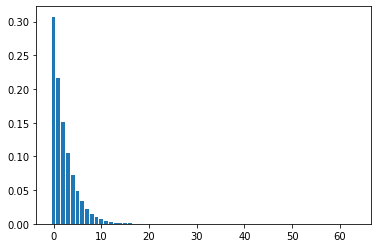

In [10]:
plt.bar(np.arange(weight.shape[1]), weight[0].cpu())

<BarContainer object of 64 artists>

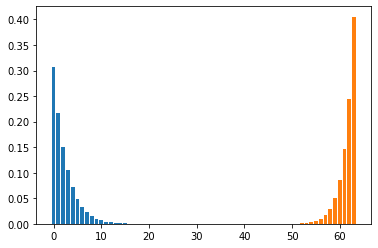

In [13]:
plt.bar(np.arange(weight.shape[1]), weight[0].cpu())
plt.bar(np.arange(weight.shape[1]-1, -1, -1), weight[1].cpu())

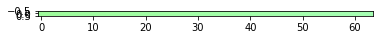

In [17]:
plt.imshow(rgb[0:1].cpu())

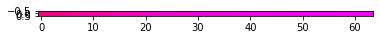

In [18]:
plt.imshow(rgb[1:2].cpu())

# Weight updating: (train)
Using small number of points (20 maybe), how the weight & color on them changes? 

In [34]:
def raw2outputs_step(raw, z_vals):
    dists = z_vals[...,1:] - z_vals[...,:-1]
    if cuda:
        dists = torch.cat([dists, torch.Tensor([1e10]).expand(dists[...,:1].shape).cuda()], -1)
    else:
        dists = torch.cat([dists, torch.Tensor([1e10]).expand(dists[...,:1].shape)], -1)
    
    rgb = torch.sigmoid(raw[...,:3])
    alpha = sigma2alpha(raw[...,3], dists)
    
    # import pdb; pdb.set_trace()
    if cuda:
        weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)).cuda(), 1.-alpha + 1e-10], -1), -1)[..., :-1]
    else:
        weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)), 1.-alpha + 1e-10], -1), -1)[..., :-1]
    # import pdb; pdb.set_trace()
    rgb_map = torch.sum(weights[...,None] * rgb, -2)
    return rgb_map, weights, rgb   

def render_rays_step(rays_o, rays_d, view_dirs, network_fn):
    near = 0
    far = 4
    n_samples = 64
    if cuda:
        z_vals = linear_sample(near, far, n_samples).cuda()
    else:
        z_vals = linear_sample(near, far, n_samples)
    # import pdb; pdb.set_trace()

    pts = rays_o[...,None,:] + torch.stack([torch.cos(rays_d)[...,None] * z_vals[None, ...], torch.sin(rays_d)[...,None] * z_vals[None, ...]], -1)
    raw = network_fn(torch.cat([pts, view_dirs[...,None, None].expand((-1, n_samples, 1))],-1))
    return raw, z_vals

In [55]:
import torch.nn as nn
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
class NeRF_Debug(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.relu = nn.functional.relu
        self.xyz_encoding_dims = 2
        self.viewdir_encoding_dims = 1
        self.hidden_size = hidden_size = 128
        self.layer1 = nn.Linear(self.xyz_encoding_dims, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3_1 = nn.Linear(hidden_size, 1)
        self.layer3_2 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(
            self.viewdir_encoding_dims + hidden_size, hidden_size
        )
        self.layer5 = nn.Linear(hidden_size, hidden_size)
        self.layer6 = nn.Linear(hidden_size, 3)

    def forward(self, x):
        x, view = x[..., :-1], x[..., -1:]
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        sigma = self.layer3_1(x)
        feat = self.relu(self.layer3_2(x))
        x = torch.cat((feat, view), dim=-1)
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        c = self.layer6(x)
        raw = torch.cat((c, sigma), dim=-1)
        return raw

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        y = y.float()
        # import pdb; pdb.set_trace()
        rays_d = x[:, 2]
        rays_o = x[:, :2]
        view_dirs = rays_d
        raw, z_vals = render_rays_step(rays_o, rays_d, view_dirs, self.forward)
        # import pdb; pdb.set_trace()
        y_hat, weight, rgb = raw2outputs_step(raw, z_vals)
        step_size = 10
        if self.global_step % step_size == 0:
            torch.save(weight, 'weight_{}.pth'.format(self.global_step // step_size))
            torch.save(rgb, 'rgb_{}.pth'.format(self.global_step // step_size))
        # import pdb; pdb.set_trace()
        loss = F.mse_loss(y_hat, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, betas=(0.9, 0.999))
        return optimizer


In [57]:
import time
model = NeRF_Debug()
trainer = pl.Trainer(gpus=1, max_steps=150)
dataset = OneDCurveData()
train_loader = DataLoader(dataset, batch_size=64)
trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type   | Params
------------------------------------
0 | layer1   | Linear | 384   
1 | layer2   | Linear | 16.5 K
2 | layer3_1 | Linear | 129   
3 | layer3_2 | Linear | 16.5 K
4 | layer4   | Linear | 16.6 K
5 | layer5   | Linear | 16.5 K
6 | layer6   | Linear | 387   
------------------------------------
67.1 K    Trainable params
0         Non-trainable params
67.1 K    Total params
0.268     Total estimated model params size (MB)


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s, loss=5.48e-05, v_num=48]


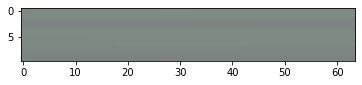

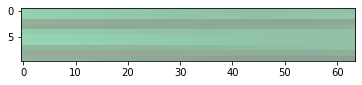

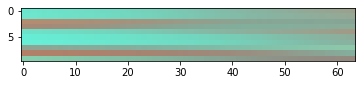

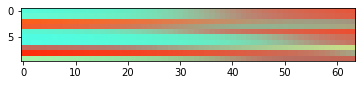

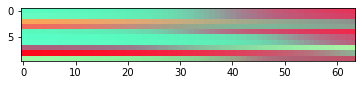

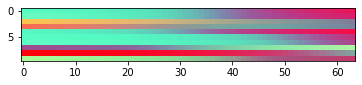

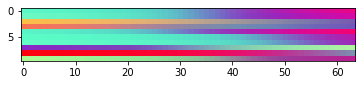

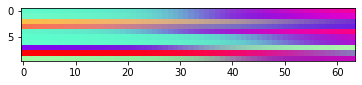

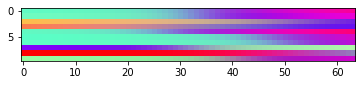

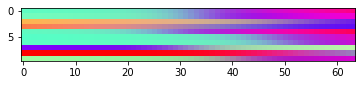

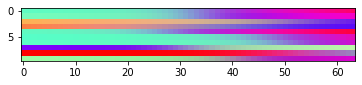

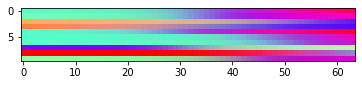

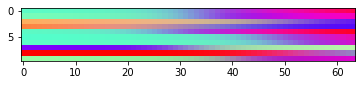

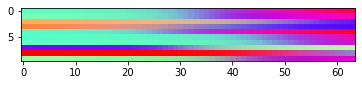

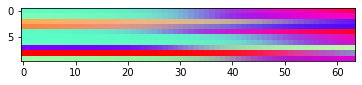

In [58]:
with torch.no_grad():
    for i in range(15):
        rgb = torch.load('rgb_{}.pth'.format(i))
        weight = torch.load('weight_{}.pth'.format(i))
        plt.imshow(rgb.cpu())
        plt.show()
        # print(weight.shape)
        

In [38]:
with torch.no_grad():
    fig, axs = plt.subplots(10)
    for i in range(15):
        # rgb = torch.load('rgb_{}.pth'.format(i))
        weight = torch.load('weight_{}.pth'.format(i))
        
        axs[i]
        # plt.imshow(rgb.cpu())
        plt.show()

torch.Size([10, 64, 3])

# More views & more sampling points 

# Does it matter to keep sampling on each ray, or we can fix that (train)